In [29]:
import os
import sys
import re
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats


from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')
sys.path.insert(1, '../../demo/fuzzy-test/python/')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Helper Functions to Parse Files


In [30]:
def load_liveInfo(directory):
    # FileFormat
    #
    # avgParticlesPerCell: 0.145314
    # cutoff: 3.000000
    # domainSizeX: 115.000000
    # domainSizeY: 215.000000
    # domainSizeZ: 145.000000
    # estimatedNumNeighborInteractions: 289010
    # maxParticlesPerCell: 26
    # minParticlesPerCell: 0
    # numCells: 137592
    # numEmptyCells: 131716
    # numHaloParticles: 0
    # numParticles: 19994
    # particleSize: 128
    # particleSizeNeededByFunctor: 72
    # particlesPerBlurredCellStdDev: 0.359923
    # particlesPerCellStdDev: 0.018441
    # rebuildFrequency: 10
    # skin: 1.000000
    # threadCount: 12

    def parseText(text):
        data = {}
        for line in text.split("\n"):
            if len(line) > 0:
                key, value = line.split(":")
                data[key.strip()] = float(value.strip())
        return data

    with open(directory + "/live_info_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data


def load_best_configs(directory):
    # LineFormat
    #
    # Configuration: {Container: $A$ , CellSizeFactor: $B$ , Traversal: $C$ , Load Estimator: $D$ , Data Layout: $E$ , Newton 3: $F$}

    def parseText(text):
        rankings = []
        regex = r"Configuration: {Container: (.*) , CellSizeFactor: (.*) , Traversal: (.*) , Load Estimator: (.*) , Data Layout: (.*) , Newton 3: (.*)}"

        for line in text.split("\n"):
            match = re.search(regex, line)
            if match:
                data = {
                    "Container": match.group(1),
                    "CellSizeFactor": float(match.group(2)),
                    "Traversal": match.group(3),
                    "Load Estimator": match.group(4),
                    "Data Layout": match.group(5),
                    "Newton 3": match.group(6),
                }
                rankings.append(data)

        return rankings

    with open(directory + "/best_configs_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data

# Load Data from Folders


In [31]:
dataSet = {}

directories = []
for root, dirs, files in os.walk("../../data/data-wsl2-uniform-cubes/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


# Always load the top 3 configurations to get more training data

for directory in directories:
    liveinfo = load_liveInfo(directory)
    best_config = load_best_configs(directory)

    for i, config in enumerate(best_config):
        if not "ranking" in dataSet:
            dataSet["ranking"] = []
        dataSet["ranking"].append(i)

        for key in config:
            if not key in dataSet:
                dataSet[key] = []
            dataSet[key].append(config[key])

        for key in liveinfo:
            if not key in dataSet:
                dataSet[key] = []
            dataSet[key].append(liveinfo[key])

df = pd.DataFrame(dataSet)

# Define Interesting Data to observe


In [32]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    # "threadCount",
    "ranking",
]

outputs = [
    "Container",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Data Layout",
    "Newton 3",
]

# Filter Data / Outliers


In [33]:
# Remove any rows where colum lies outside 3 standard deviations
df = df[(np.abs(stats.zscore(df[inputs])) < 3).all(axis=1)]

# only keep the top configurations
df = df[df["ranking"] < 1]

X, y = df[inputs], df[outputs]

# Create Train and Test Data


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [35]:
pd.concat([X_train, y_train], axis=1)

avgParticlesPerCell  maxParticlesPerCell  numParticles  \
3472             2.639876                 20.0       72227.0   
1638             0.005144                  4.0       19468.0   
3222             4.477612                  6.0      117600.0   
1934             0.280839                  4.0        5464.0   
3172             0.186184                  4.0        7358.0   
2584             1.122150                  8.0       21065.0   
892              0.564113                  9.0       17835.0   
1884             0.000512                  2.0        1936.0   
2284            16.369048                 27.0       11000.0   
1538             4.076557                  6.0      150800.0   
350              0.528679                  6.0      120000.0   
2934             0.464018                 20.0      127431.0   
2184             0.145314                 26.0       19994.0   
2384             0.000112                  1.0          54.0   
2534             0.001012                  1.0          32.0   
1038             0.041948                  6.0      158744.0   
3126             6.666667                 35.0        1200.0   
2134            17.148526                 27.0      121000.0   
1338             0.250206                  1.0        7600.0   
2084             0.002519                  1.0          49.0   
696              0.005287                  1.0        1200.0   
2734             2.586672                 23.0       48557.0   
150              4.523221                  8.0      167323.0   
942              0.000000                  0.0           0.0   
400              0.827672                  7.0        5677.0   
3076             0.203542                  3.0        1000.0   
300              2.486029                  8.0      121000.0   
1984             0.000665                  1.0        1600.0   
3572             1.170264                  9.0      120000.0   
3818             0.081417                  2.0         400.0   
3772             8.163265                 28.0        1200.0   
846              0.666667                  5.0         120.0   
1488             1.741124                 11.0      120000.0   
2234             2.639876                 20.0       72227.0   
1388             1.017708                  5.0        5000.0   
2634             0.000000                  0.0           0.0   
1288             0.006650                  2.0       16000.0   
3272             2.871264                 15.0       19694.0   
3522             2.321499                 11.0      160000.0   
596              5.830904                 19.0       16000.0   
1738             4.855042                 19.0      153497.0   
3672             0.229548                  6.0       31584.0   
3372             0.020354                  2.0         100.0   
2034             5.445983                 23.0       37354.0   
1588             2.719414                 14.0       85977.0   
2334             1.195457                  3.0       36312.0   
3622             2.783304                  6.0      102960.0   
50               1.680961                 13.0       31555.0   
2884             2.826994                 20.0       55002.0   
1138             1.424791                  8.0        7000.0   
100              0.020354                  2.0         100.0   
1238             0.004144                  2.0         307.0   
1088             1.870850                 20.0       73936.0   
3322             0.020354                  2.0         100.0   
796              0.374085                  1.0      121000.0   
2784             0.001148                  2.0         553.0   

      particlesPerCellStdDev  ranking           Container  \
3472                0.005599        0    VerletListsCells   
1638                0.007365        0  VerletClusterLists   
3222                0.001808        0    VerletListsCells   
1934                0.014317        0         LinkedCells   
3172                0.012643        0  VerletCluster

# Make some plots about the data


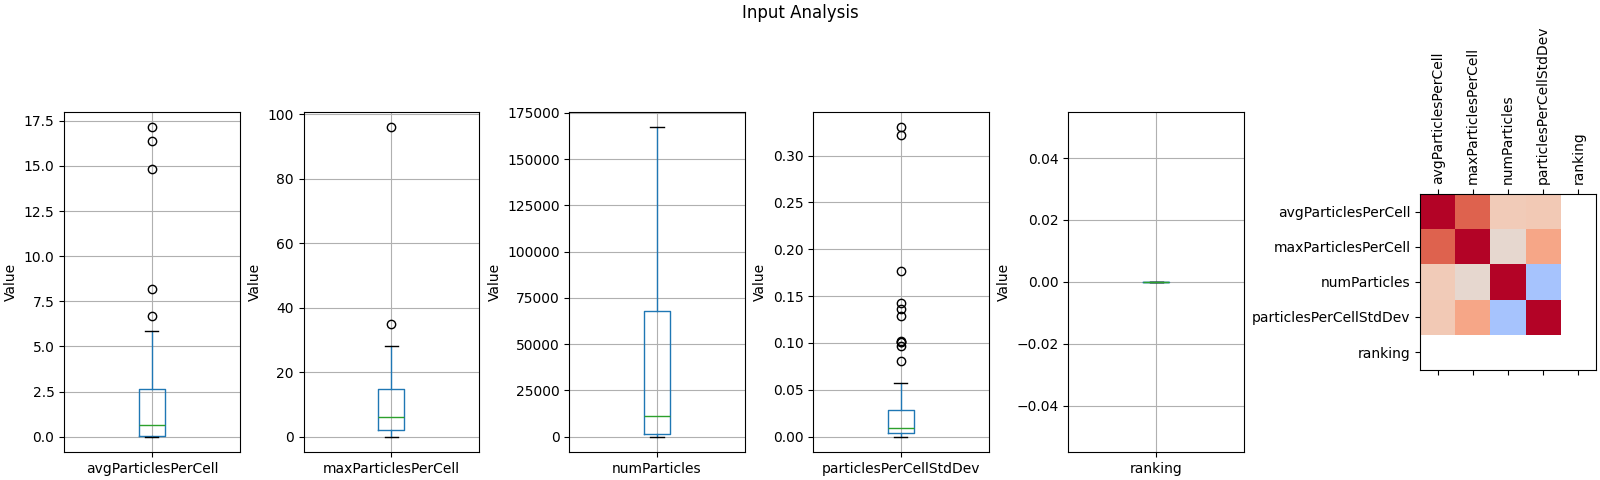

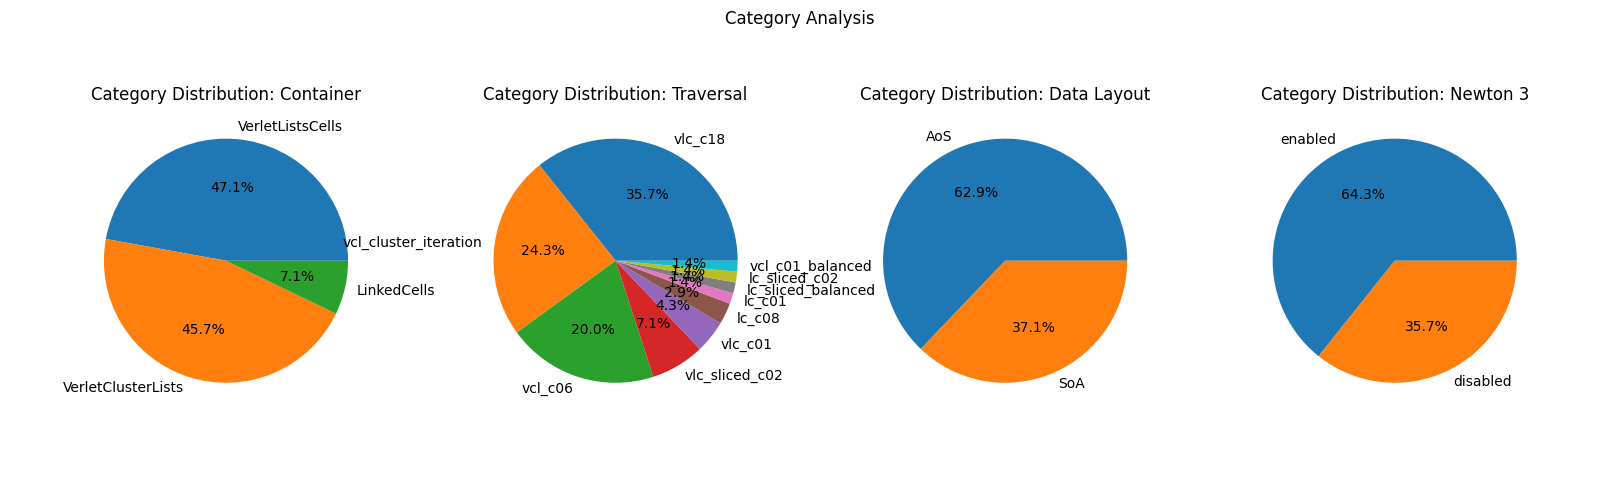

In [36]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)
for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()
    ax1[i].pie(y_count, labels=y_count.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [37]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4]

CCP_ALPHA = {
    "Container": 0.2,
    "Traversal": 0.06,
    "Data Layout": 0.15,
    "Newton 3": 0.13,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 2

Training on 56 samples
Number of rules 51:
	Container (9 rules)
	Traversal (25 rules)
	Data Layout (9 rules)
	Newton 3 (8 rules)


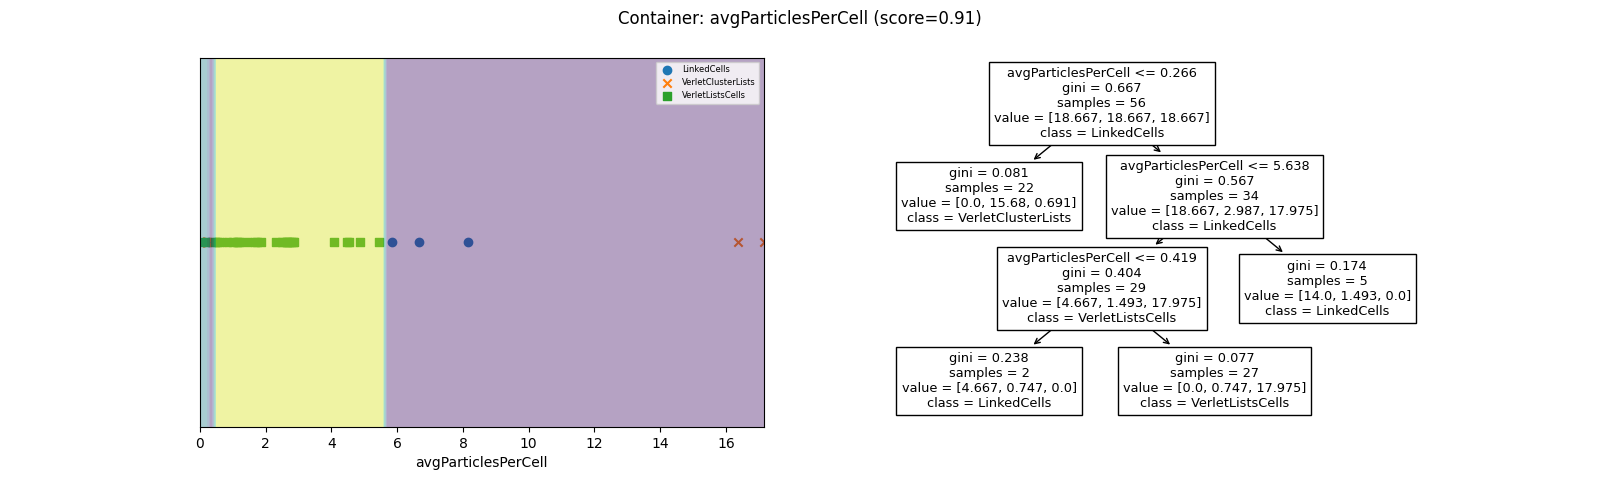

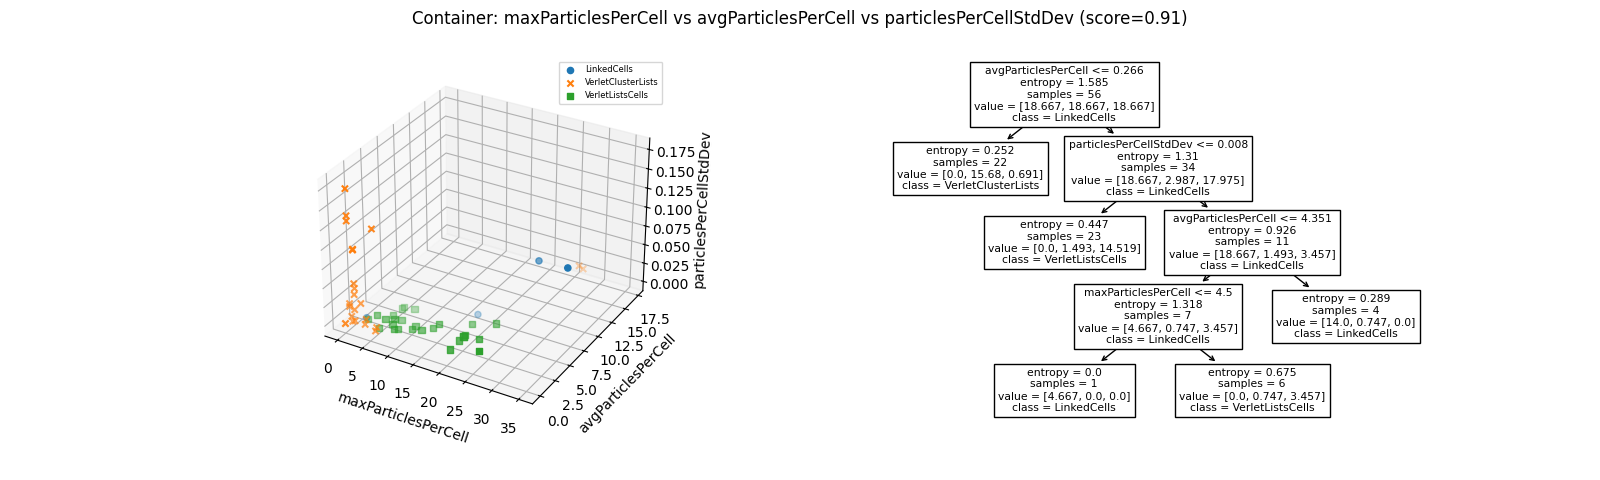

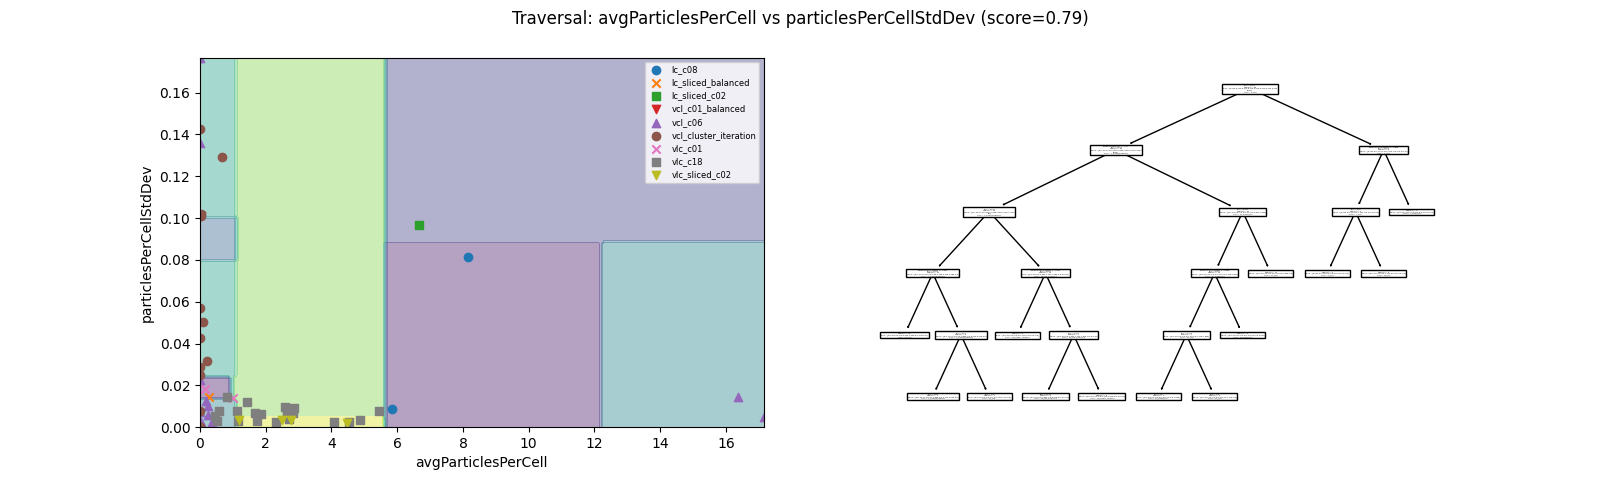

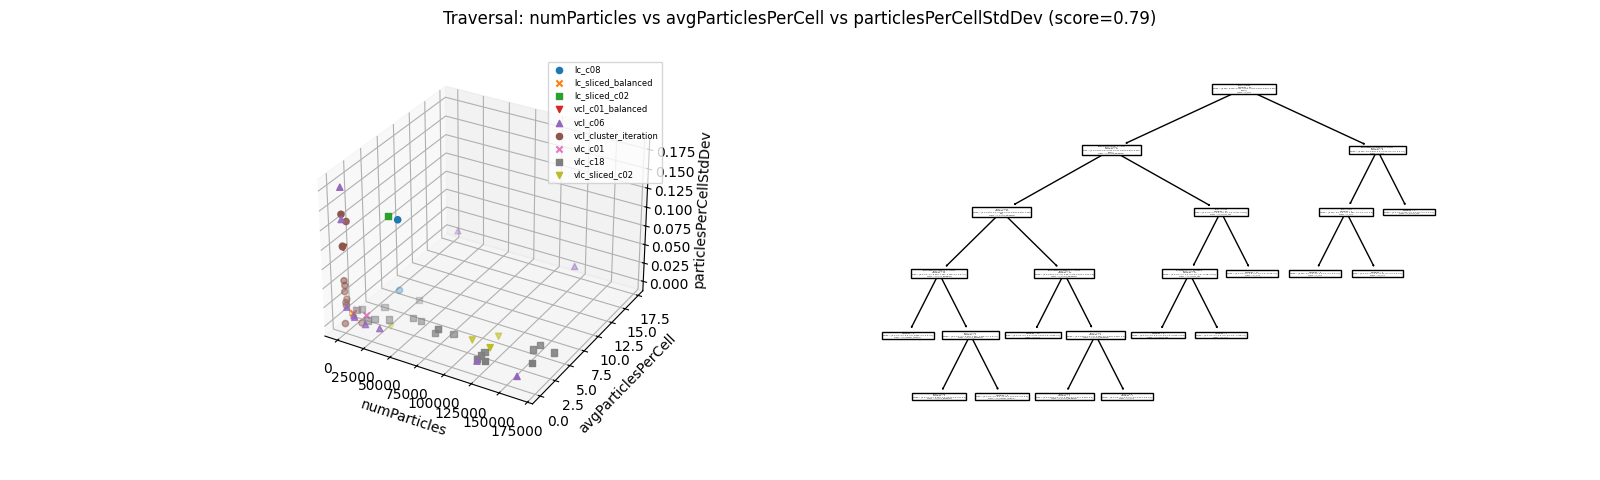

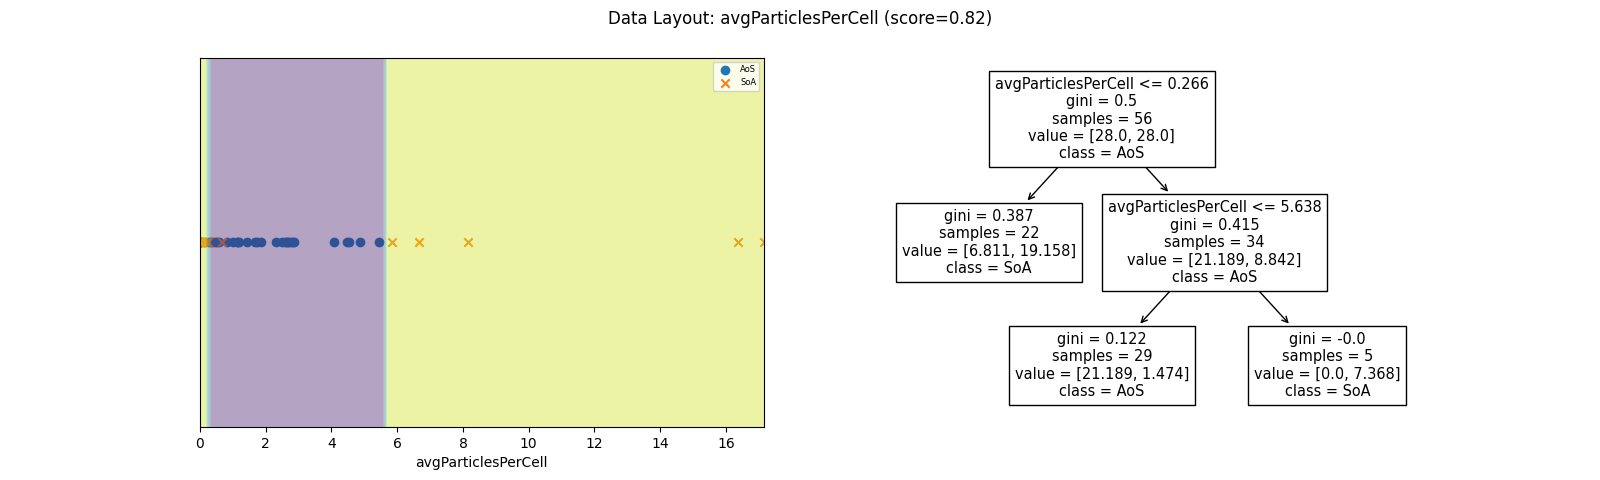

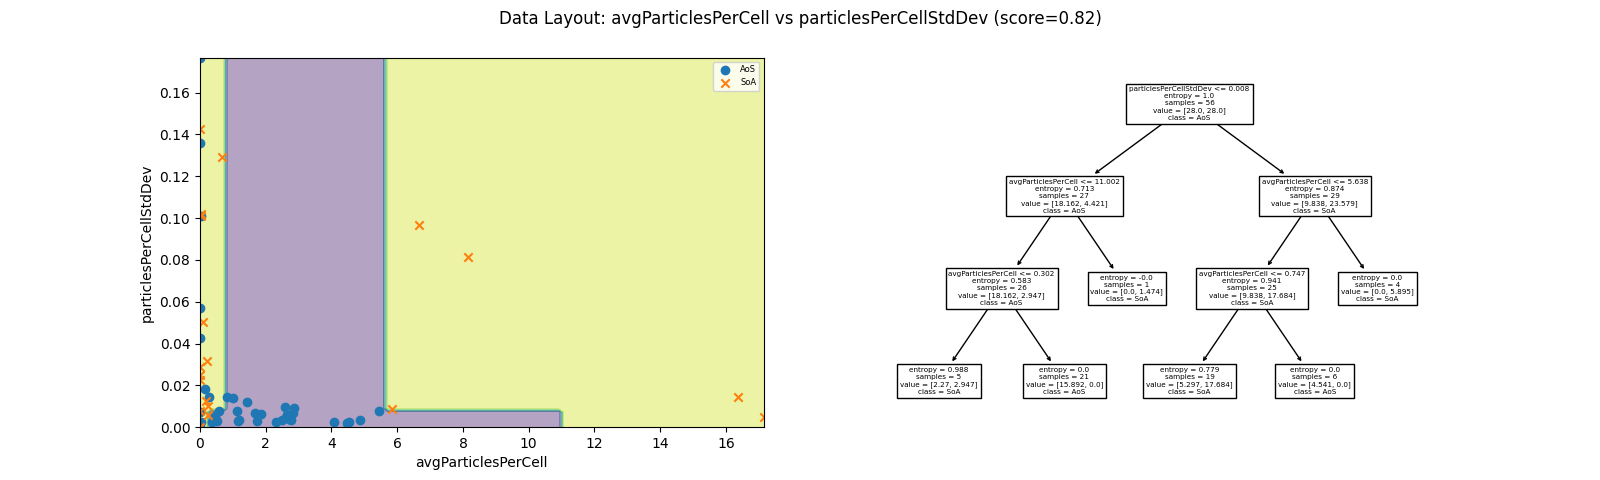

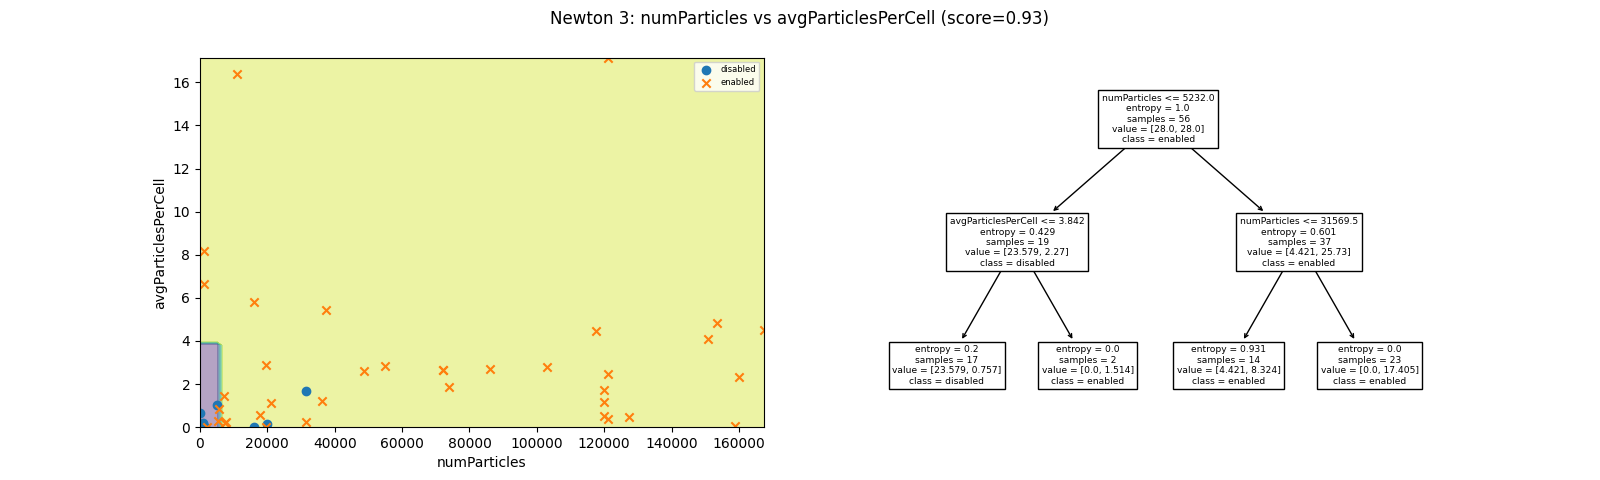

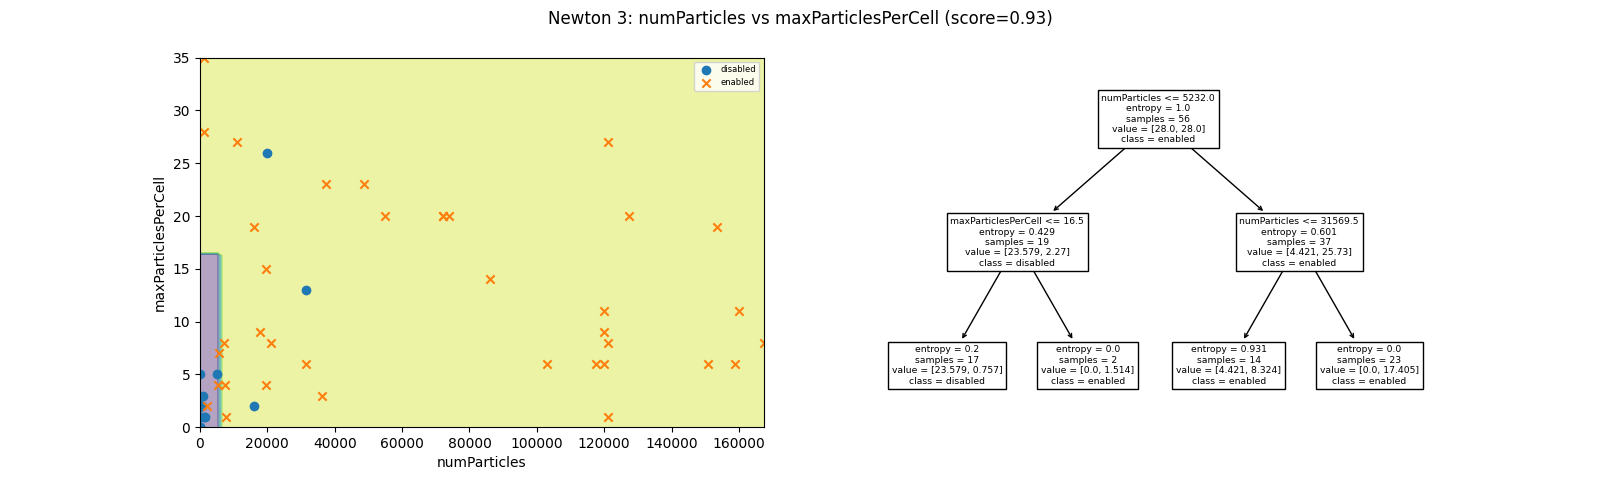

In [38]:
auto_rules = create_auto_rules(X_train, y_train, None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

# Approach 1

Is a self made approach to use the rules of the Decision Tree to create a Fuzzy System.


avgParticlesPerCell: [-inf, 0.266, 0.302, 0.419, 0.747, 0.923, 1.07, 3.842, 4.351, 5.638, 11.002, 12.266, inf]
avgParticlesPerCell: [-inf, 0.266, 0.747, 1.07, 3.842, 4.351, 5.638, 11.002, 12.266, inf]

particlesPerCellStdDev: [-inf, 0.002, 0.003, 0.004, 0.008, 0.013, 0.024, 0.079, 0.089, 0.101, inf]
particlesPerCellStdDev: [-inf, 0.002, 0.008, 0.013, 0.024, 0.079, 0.089, 0.101, inf]

maxParticlesPerCell: [-inf, 4.5, 16.5, inf]
maxParticlesPerCell: [-inf, 4.5, 16.5, inf]

numParticles: [-inf, 1768.0, 5232.0, 12835.5, 31569.5, 135900.0, inf]
numParticles: [-inf, 1768.0, 12835.5, 31569.5, 135900.0, inf]

delta_x = 486.1723097404068, number of points = 8.850883697177398e-07, should be at least 10
delta_x = 486.1723097404068, number of points = 8.850883145313518e-07, should be at least 10


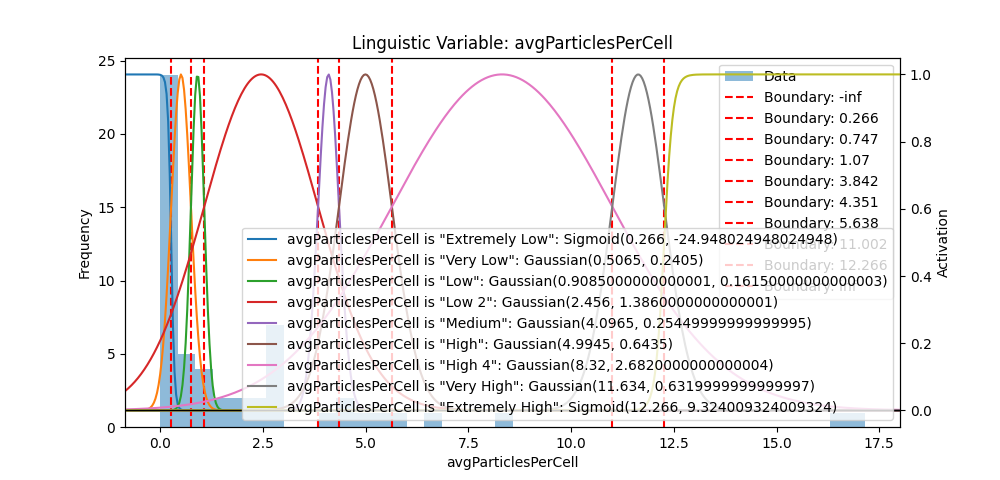

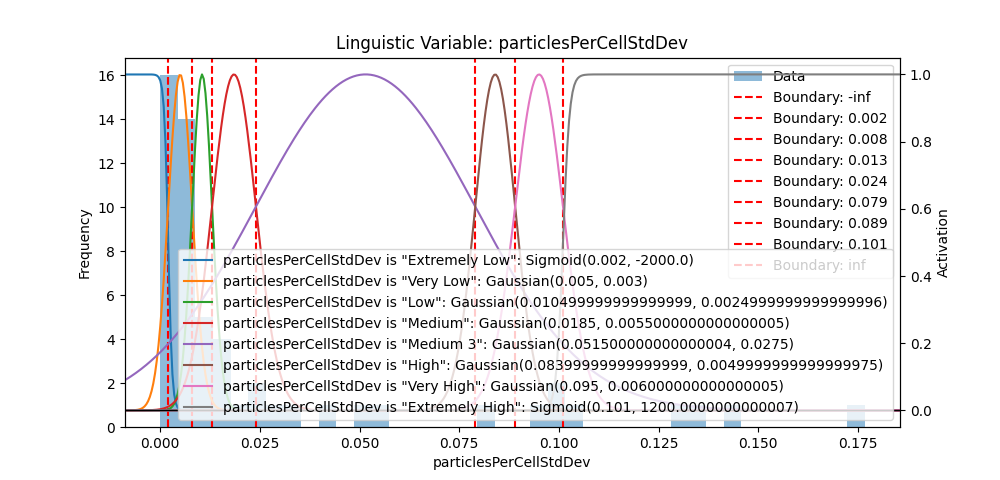

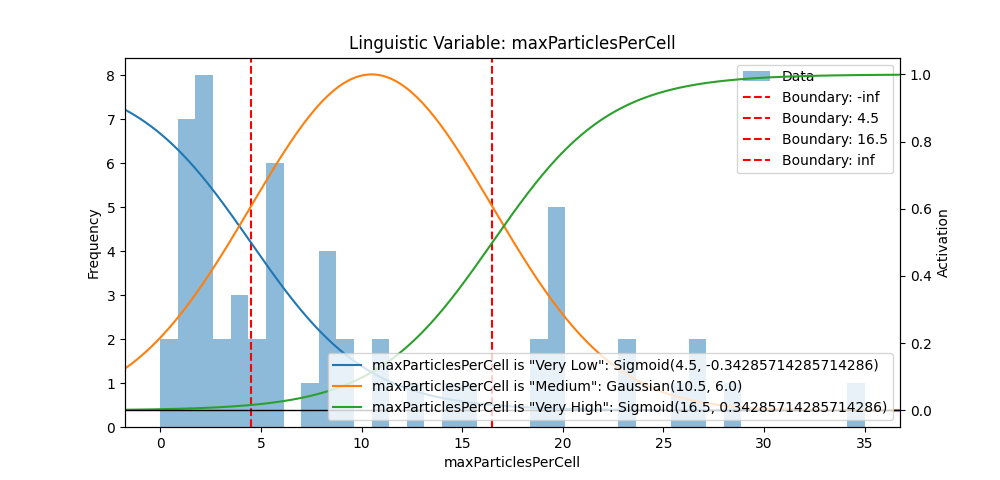

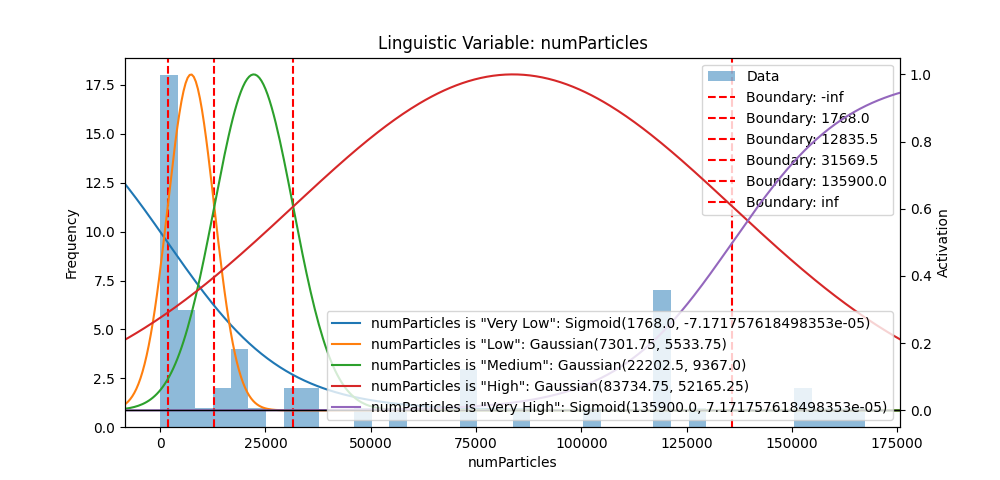

In [39]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Create Rules Approach 1


# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


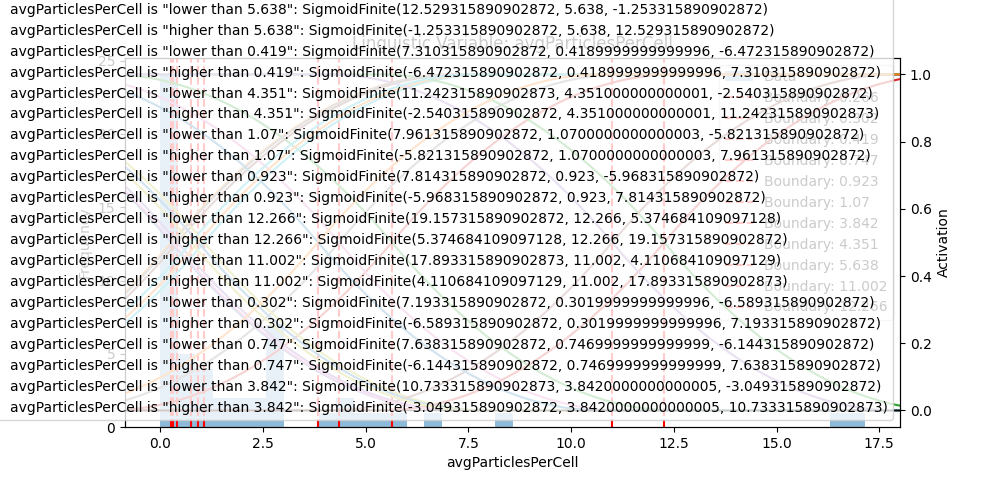

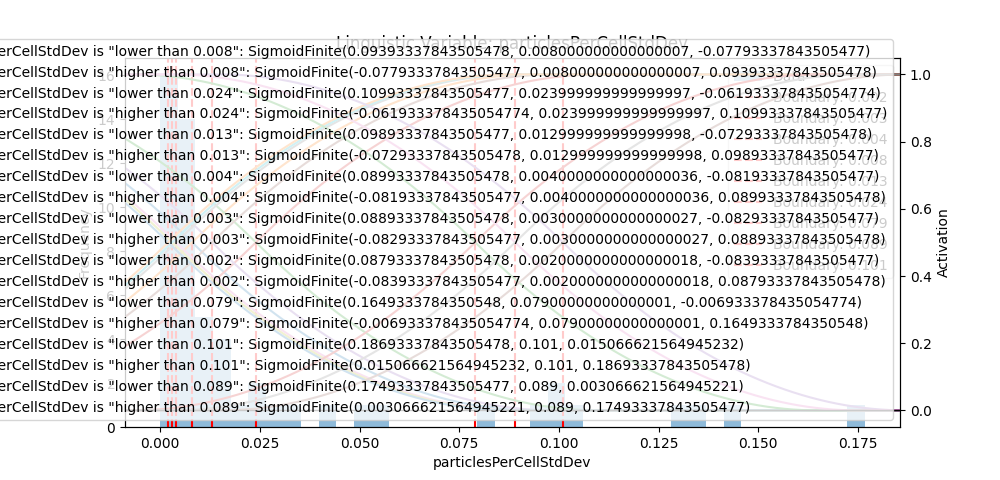

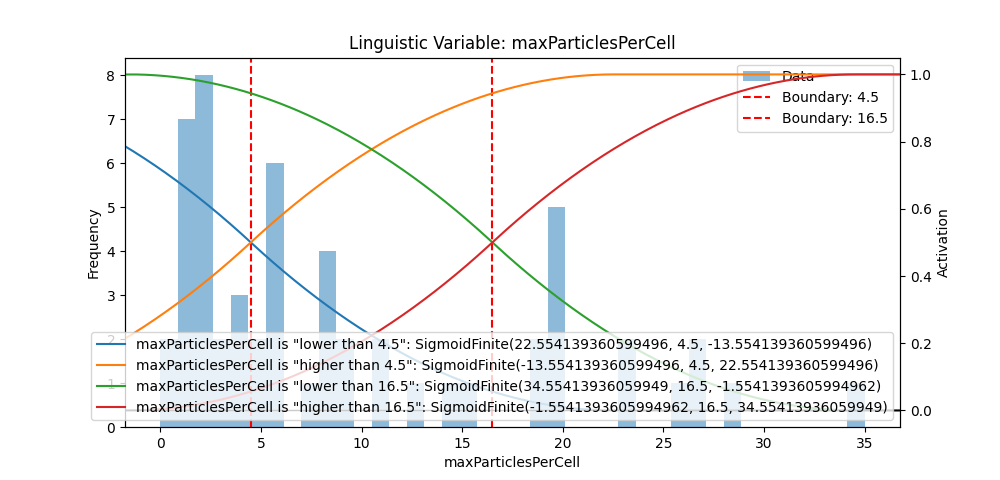

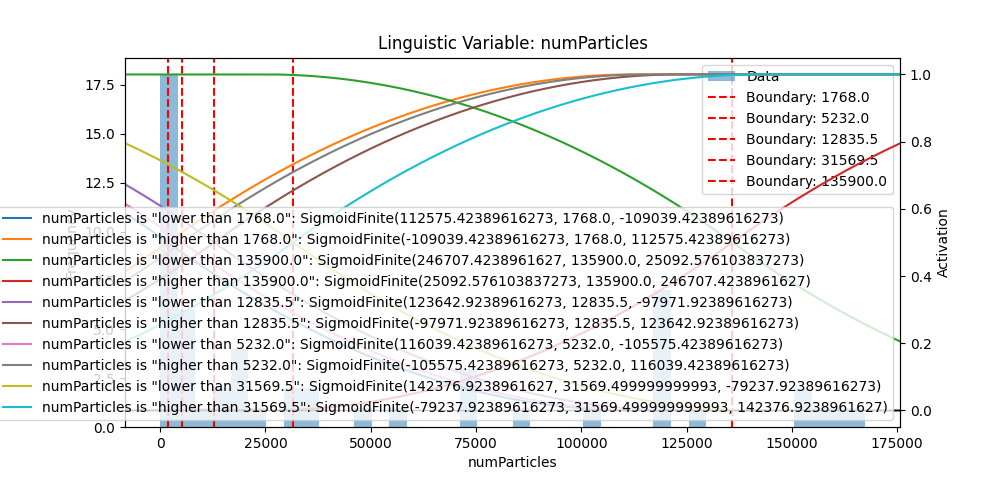

In [40]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

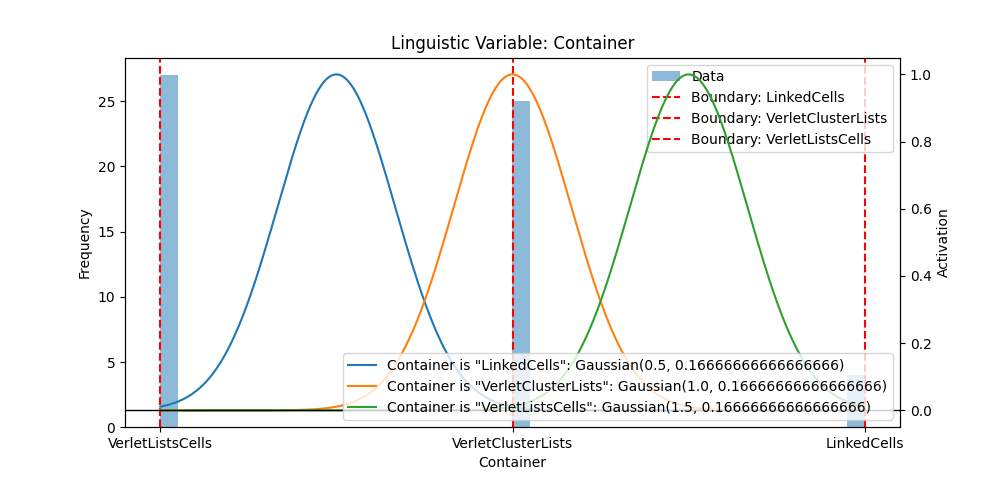

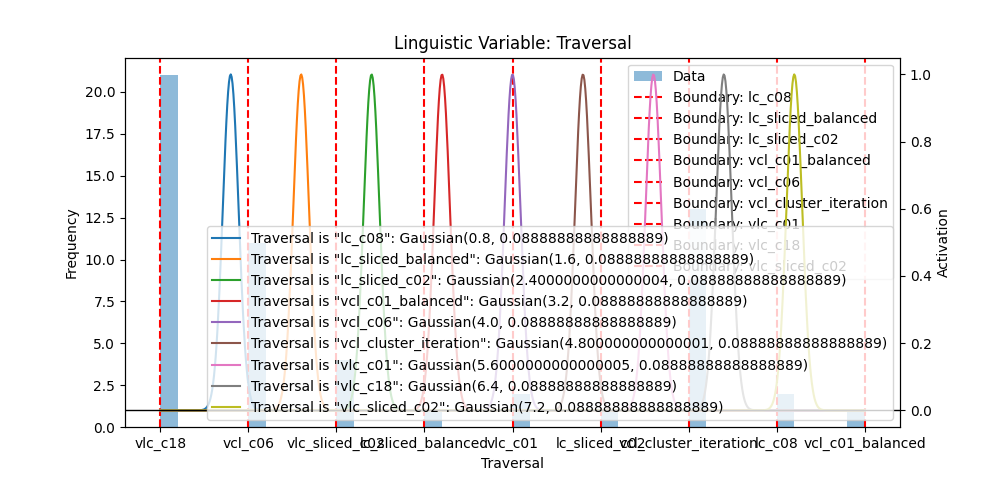

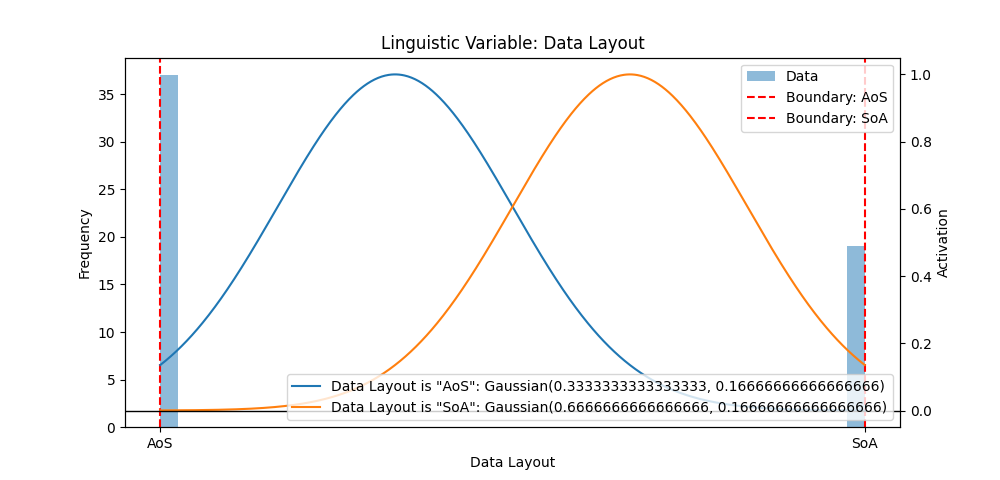

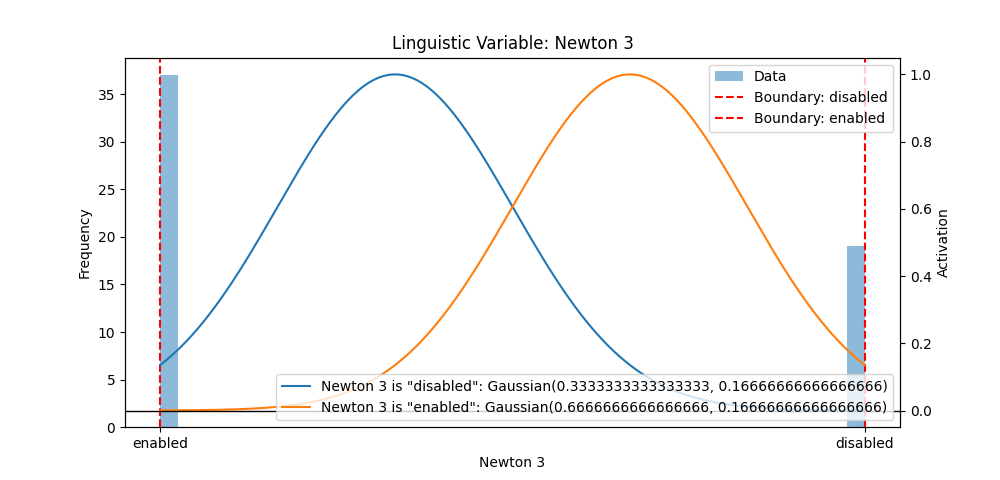

In [41]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [42]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "avgParticlesPerCell" range: (-6.891315890902872, 24.03984189090287)
	"Extremely Low": Sigmoid(0.266, -24.948024948024948)
	"Very Low": Gaussian(0.5065, 0.2405)
	"Low": Gaussian(0.9085000000000001, 0.16150000000000003)
	"Low 2": Gaussian(2.456, 1.3860000000000001)
	"Medium": Gaussian(4.0965, 0.25449999999999995)
	"High": Gaussian(4.9945, 0.6435)
	"High 4": Gaussian(8.32, 2.6820000000000004)
	"Very High": Gaussian(11.634, 0.6319999999999997)
	"Extremely High": Sigmoid(12.266, 9.324009324009324)

FuzzyVariable: domain: "particlesPerCellStdDev" range: (-0.08593337843505477, 0.2626203784350548)
	"Extremely Low": Sigmoid(0.002, -2000.0)
	"Very Low": Gaussian(0.005, 0.003)
	"Low": Gaussian(0.010499999999999999, 0.0024999999999999996)
	"Medium": Gaussian(0.0185, 0.0055000000000000005)
	"Medium 3": Gaussian(0.051500000000000004, 0.0275)
	"High": Gaussian(0.08399999999999999, 0.0049999999999999975)
	"Very High": Gaussian(0.095, 0.006000000000000005)
	"Extremely High": Sig